# Pycle demo 4: sketching mixed integer-continuous data, and compressive learning of histograms
In this last demo notebook, we show several remaining features of `pycle`:
1. How to define a meaningful sketch function when some features of the dataset are categorical values.
1. How to extract histograms from sketches.
1. How to perform "usual" compressive learning algorithms (k-means or GMM) on only the continuous (i.e. relevant) dimensions.

We assume that you have installed `pycle` with `pip` or that you have the `pycle` folder in the same directory as this notebook.

In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Fix the random seed for reproducibility
np.random.seed(42)

We generate a GMM dataset, but map some of the entries to an integer value to simulate a mixed continuous-categorical dataset.

Bounds:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 2. 4. 2. 4. 1.]]


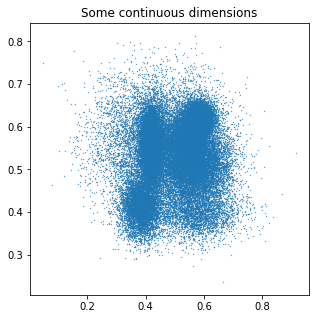

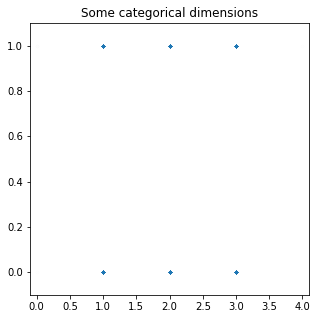

In [2]:
from pycle.utils import generatedataset_GMM

d = 10   # Dimension
K = 8     # Number of Gaussians
n = 50000 # Number of samples we want to generate
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = generatedataset_GMM(d,K,n,normalize='l_inf-unit-ball',balanced=False) 

# Normalize in [0,1]^d
X = (X+1)/2

d_intg = 5 # Number of categorical dimensions

# Chose a number of categories for each cat. dimension
nb_cat_per_dim = np.zeros(d)
for d_i in range(d-d_intg,d):
    # Number of categories
    nb_cats = 2 + np.round(np.random.exponential(2.5))
    nb_cat_per_dim[d_i] = nb_cats
    
    X[:,d_i] = np.floor(nb_cats*X[:,d_i])

# Bounds on the dataset, necessary for compressive k-means
bounds = np.array([np.zeros(d),np.ones(d)]) # We assumed the data is normalized between 0 and 1
# Integer data is normalized to lie at the int values between 0 and C-1
bounds[1,np.where(nb_cat_per_dim)[0]] *= nb_cat_per_dim[np.where(nb_cat_per_dim)[0]] - 1 

print("Bounds:\n",bounds)

# Visualize the dataset
plt.figure(figsize=(5,5))
plt.title("Some continuous dimensions")
plt.scatter(X[:,0],X[:,1],s=0.1)
plt.show()

plt.figure(figsize=(5,5))
plt.title("Some categorical dimensions")
plt.scatter(X[:,8],X[:,9],s=10,alpha=0.005)
plt.xlim([-0.1,nb_cat_per_dim[8]-0.9])
plt.ylim([-0.1,nb_cat_per_dim[9]-0.9])
plt.show()


Let us now generate a sketch for this data. A specific distibution for categorical data is built-in the `drawFrequencies` function, we just need to specify which dimensions hold categorical data and how much categories we expect per dimension, through `nb_cat_per_dim`.

In [3]:
import pycle.sketching as sk

# As usual: sketch dimension, draw the frequencies
m = 20*K*d # Sketch dimension
Sigma = (1/400)*np.eye(d)
# Draw frequencies: notice the nb_cat_per_dim input
Omega = sk.drawFrequencies("FoldedGaussian",d,m,Sigma,nb_cat_per_dim=nb_cat_per_dim) 

# Draw the dithering xi
xi = np.zeros(m)

# Define the feature map as the complex universal quantization
Phi = sk.SimpleFeatureMap("complexexponential",Omega,xi,c_norm='normalized') 

# Compute the sketch with those quantized features
z = sk.computeSketch(X,Phi)

Keep in mind that the `nb_cat_per_dim` argument will have to be passed to the learning functions. Now, let's extract the histogram from the sketch.

[1.69674643e-05 2.06318425e-05 2.72957373e-05 4.04013063e-05
 8.72923313e-05 2.28602818e-02 1.22026475e-01 1.22098204e-01
 1.22100839e-01 1.22107557e-01 1.22107828e-01 1.22098477e-01
 1.22098454e-01 1.22015671e-01 1.06316580e-04 8.44743029e-05
 3.86273345e-05 2.69613561e-05 2.06260653e-05 1.66194988e-05]


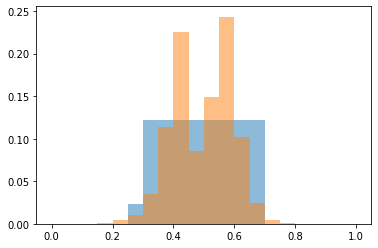

[1.31620472e-05 1.77311183e-05 1.88780153e-05 2.55212067e-05
 4.33044384e-05 1.71796256e-06 2.82792878e-02 1.21358135e-01
 1.21416902e-01 1.21408923e-01 1.21419146e-01 1.21419076e-01
 1.21403599e-01 1.21395315e-01 1.21380821e-01 2.55342235e-04
 6.86301092e-05 3.44980289e-05 2.22405968e-05 1.77703165e-05]


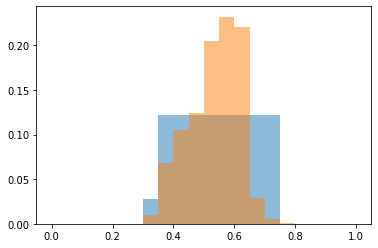

[2.29119929e-05 2.96303621e-05 4.57050806e-05 8.95550768e-05
 4.02498765e-03 1.21793536e-01 1.21799456e-01 1.21807167e-01
 1.21809417e-01 1.21805446e-01 1.21802980e-01 1.21784672e-01
 1.21748502e-01 2.13136215e-02 3.34051383e-05 2.78699885e-05
 2.04300469e-05 1.54163621e-05 1.35138444e-05 1.17773861e-05]


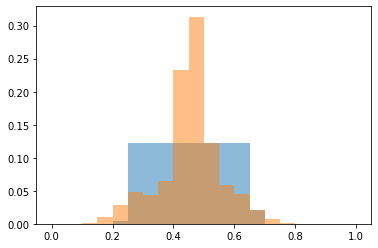

[1.30878149e-06 1.94959562e-06 1.31633076e-06 2.37023347e-06
 3.95677355e-06 6.41371499e-06 5.39264197e-02 1.21831742e-01
 1.21832723e-01 1.21834153e-01 1.21833715e-01 1.21834364e-01
 1.21831913e-01 1.21827653e-01 9.32138423e-02 6.54685731e-06
 3.59469115e-06 2.29258852e-06 2.03846646e-06 1.68687119e-06]


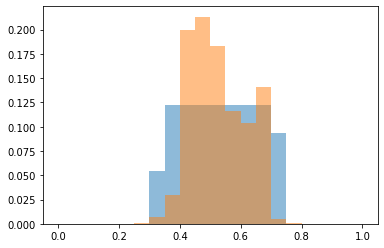

[5.94482189e-06 7.10375340e-06 8.96968107e-06 9.31997508e-06
 1.33743871e-05 5.48210727e-02 1.22748503e-01 1.22744130e-01
 1.22736574e-01 1.22737644e-01 1.22736824e-01 1.22733659e-01
 1.22723160e-01 8.59080393e-02 2.49540517e-05 1.32066958e-05
 9.24007003e-06 7.01613595e-06 5.98939957e-06 5.27530358e-06]


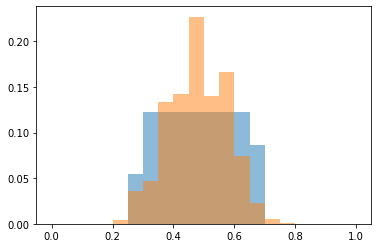

[0.00344056 0.97898644 0.017573  ]


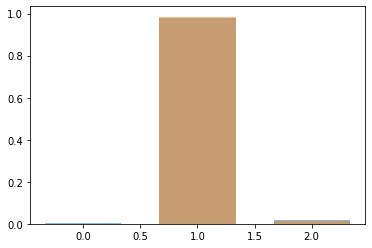

[2.20923995e-03 3.84638258e-02 7.32689564e-01 2.26402342e-01
 2.35028307e-04]


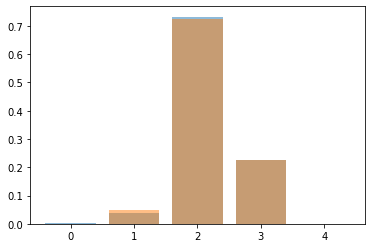

[5.69818429e-02 9.42983037e-01 3.51204819e-05]


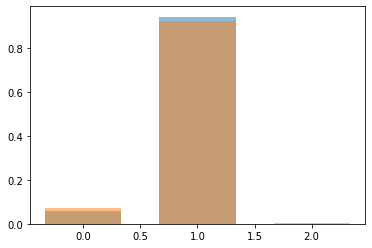

[0.00079532 0.04722534 0.7576118  0.19353887 0.00082867]


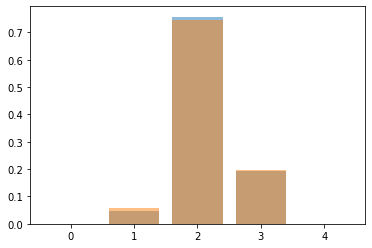

[0.56892396 0.43107604]


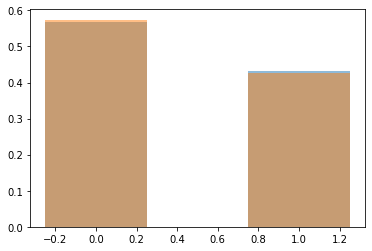

In [7]:
import pycle.compressive_learning as cl

bins_cont = 20
domain = bounds.T
for d_i in range(d):
    # Determine number of bins to use
    is_integer_dimension = False
    if nb_cat_per_dim[d_i] > 0:
        is_integer_dimension = True
        bins = int(nb_cat_per_dim[d_i])
    else:
        bins = bins_cont

    # Ground-truth histogram
    bins_ed = np.linspace(domain[d_i,0],domain[d_i,1] + is_integer_dimension,bins+1)
    bins_cen = (bins_ed[1:] + bins_ed[:-1])/2 - (0.5 if is_integer_dimension else 0)
    h_GT,_ = np.histogram(X[:,d_i], bins=bins_ed, weights=np.ones(n)/n)

    # Histogram from sketch
    #h_CL = cl.histogramFromSketch_M2M(z,Phi,domain,d_i,nb_cat_per_dim,bins_cont=bins_cont,project_on_probabilitySimplex=False,reg_rho=0.)
    h_CL = cl.CL_histogram_MMD(z,Phi,domain,d_i,nb_cat_per_dim,bins_cont=bins_cont,project_on_probabilitySimplex=False,reg_max_alpha=3)
    h_CL = h_CL/np.sum(h_CL)
    print(h_CL)
    
    plt.figure()
    plt.bar(bins_cen,h_CL,width=(domain[d_i,1]-domain[d_i,0])/bins,alpha=0.5)
    plt.bar(bins_cen,h_GT,width=(domain[d_i,1]-domain[d_i,0])/bins,alpha=0.5)
    plt.show()
    


In [5]:
h_CL

array([0.56892396, 0.43107604])